In [2]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

#from keras.regularizers import l2, activity_l2

import kapre 
from kapre.time_frequency import Spectrogram

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

from itertools import islice
from UtilNNDL import create_window_data
from UtilNNDL import plot_hist

In [3]:
#import the data
A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

#check the data dimensionality
print data.shape
print labels.shape

#for STFT we DO NOT swap the axes 
#data = np.swapaxes(data, 1,2)
data = data[:,:22,:]

(288, 25, 1000)
(288,)


In [4]:
#Experimental, try adding 24 zeros the the end of the matrix such that the shape is the same as in the paper
buf = np.zeros([288,22,24])
print buf.shape 
print data.shape
databuf = np.concatenate([data,buf],axis=2)
print databuf.shape

(288, 22, 24)
(288, 22, 1000)
(288, 22, 1024)


In [5]:
#Experimental, try just using just c3,cz,c4 electrodes 
data = data[:,(7,9,11),:]

In [6]:
# Remove the bad sample
data = np.delete(data,56,0)
labels = np.delete(labels,56,0)
print data.shape
print labels.shape

(287, 3, 1000)
(287,)


In [7]:
#one-hot-encode the data for use with categorical_crossentropy
labels_cata = labels - 769
labels_cata = to_categorical(labels_cata, num_classes=4)
print labels_cata

[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [8]:
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

#split data into training and testing 
train_samples = data.shape[0]-50
train_data = data[shuffle[:train_samples],:,:]
train_labels = labels_cata[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels =labels_cata[shuffle[train_samples:]]

In [9]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 3, 512)
(2370, 4)
(500, 3, 512)
(500, 4)


# Model Testing

In [10]:
#STFT CNN

SR = 250
src_cute, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])
    
    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    np.random.seed(42)
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, data, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print "Channels"
    print model.input_shape[1:]
    src = data 
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    print src_batch.shape
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.amplitude_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)

srcshape
(3, 1000)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 63, 3)        263168      
Total params: 263,168
Trainable params: 263,168
Non-trainable params: 0
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 1s 525ms/step - loss: 1142.2498
Channels
(3, 1000)
(1, 3, 1000)
771


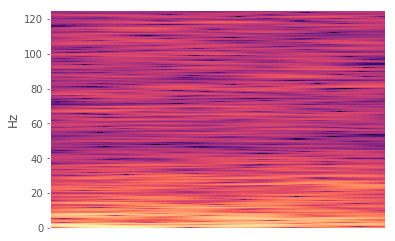

In [11]:
#Show the output of the model after STFT
src = train_data[0]
#src = databuf[0,0,:]
#src = src[np.newaxis, :] 
print "srcshape"
print src.shape
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=16, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))

check_model(model)
visualise_model(model, src)
print labels[1]

Data Shape: (2370, 3, 512)
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
trainable_stft (Spectrogr (None, 257, 64, 3)        263168      
________________________________________________________________________________
conv2d_4 (Conv2D)         (None, 246, 53, 24)       10392       
________________________________________________________________________________
batch_normalization_4 (Ba (None, 246, 53, 24)       96          
________________________________________________________________________________
max_pooling2d_4 (MaxPooli (None, 123, 26, 24)       0           
________________________________________________________________________________
activation_4 (Activation) (None, 123, 26, 24)       0           
________________________________________________________________________________
dropout_4 (Dropout)       (None, 123, 26, 24)       0           
________________________________

/home/carla/Documents/tensorflow/local/lib/python2.7/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2133 samples, validate on 237 samples
Epoch 1/30
2133/2133 [==============================] - 6s 3ms/step - loss: 4.4397 - acc: 0.2532 - val_loss: 2.2680 - val_acc: 0.1139
Epoch 2/30
2133/2133 [==============================] - 2s 1ms/step - loss: 3.2697 - acc: 0.2663 - val_loss: 1.5316 - val_acc: 0.3249
Epoch 3/30
2133/2133 [==============================] - 2s 1ms/step - loss: 2.8361 - acc: 0.2738 - val_loss: 2.7192 - val_acc: 0.2996
Epoch 4/30
2133/2133 [==============================] - 3s 1ms/step - loss: 2.5530 - acc: 0.2583 - val_loss: 1.7702 - val_acc: 0.2954
Epoch 5/30
2133/2133 [==============================] - 3s 1ms/step - loss: 2.0827 - acc: 0.2986 - val_loss: 2.5538 - val_acc: 0.3122
Epoch 6/30
2133/2133 [==============================] - 2s 1ms/step - loss: 1.9792 - acc: 0.2879 - val_loss: 2.0527 - val_acc: 0.2954
Epoch 7/30
2133/2133 [==============================] - 3s 1ms/step - loss: 1.9197 - acc: 0.2883 - val_loss: 2.0964 - val_acc: 0.2827
Epoch 8/30
2133

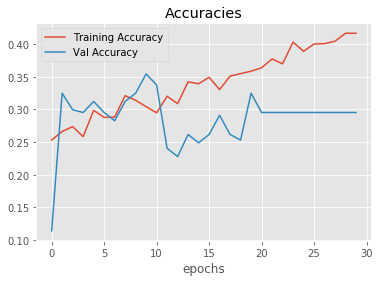

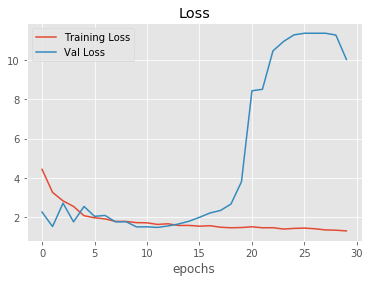

In [13]:
#STFT Model
input_data = train_data_sliced
input_labels = train_labels_sliced
test_data  
print "Data Shape: {}".format(input_data.shape)
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=8, input_shape=input_data[0].shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=True, name='trainable_stft'))
model.add(Convolution2D(24,(12, 12)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Convolution2D(48,(8, 8)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Convolution2D(96,(4, 4)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.summary(line_length=80, positions=[.33, .65, .8, 1.])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hist = model.fit(input_data, input_labels, nb_epoch=30, batch_size=512, validation_split=0.1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

In [ ]:
#model